In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Replace with your actual CSV file name if different
df = pd.read_csv("Online Retail.csv", encoding='ISO-8859-1')


In [3]:
df.head()         # View first few rows
df.info()         # Dataset structure
df.isnull().sum() # Missing values check


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ï»¿InvoiceNo  541909 non-null  object 
 1   StockCode     541909 non-null  object 
 2   Description   540455 non-null  object 
 3   Quantity      541909 non-null  int64  
 4   InvoiceDate   541909 non-null  object 
 5   UnitPrice     541909 non-null  float64
 6   CustomerID    406829 non-null  float64
 7   Country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


ï»¿InvoiceNo         0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
dtype: int64

In [4]:
# Drop rows with missing CustomerID
df = df[~df['CustomerID'].isnull()]

# (Optional) Drop Description if you don't need it
df = df.drop(columns=['Description'])


In [5]:
df.isnull().sum()

ï»¿InvoiceNo    0
StockCode       0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
dtype: int64

In [6]:
df = df[~df['ï»¿InvoiceNo'].astype(str).str.startswith('C')]


In [7]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [8]:
df.head()

,ï»¿InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [9]:
df.rename(columns={"ï»¿InvoiceNo": "InvoiceNo"}, inplace=True)


In [10]:
df.head()


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [12]:
df['InvoiceDate'].dtype


dtype('<M8[ns]')

In [13]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [14]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                         # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [15]:
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [16]:
# R Score: Lower recency = better score
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)

# F Score: Higher frequency = better score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)

# M Score: Higher monetary = better score
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)


In [17]:
# Combine into RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)


In [18]:
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)


In [19]:
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114,6
1,12347.0,2,7,4310.00,4,4,4,444,12
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,3,1,4,314,8
4,12350.0,310,1,334.40,1,1,2,112,4


In [20]:
def simple_segment(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    if r == 4 and f == 4 and m == 4:
        return 'Best Customers'
    elif f >= 3 and m >= 2:
        return 'Loyal Customers'
    elif m == 4 and f < 3:
        return 'Big Spenders'
    elif r == 1:
        return 'At Risk'
    else:
        return 'Others'


In [21]:
rfm['Segment'] = rfm.apply(simple_segment, axis=1)


In [22]:
rfm[['CustomerID', 'RFM_Segment', 'RFM_Score', 'Segment']].head()


,CustomerID,RFM_Segment,RFM_Score,Segment
0,12346.0,114,6,Big Spenders
1,12347.0,444,12,Best Customers
2,12348.0,234,9,Loyal Customers
3,12349.0,314,8,Big Spenders
4,12350.0,112,4,At Risk


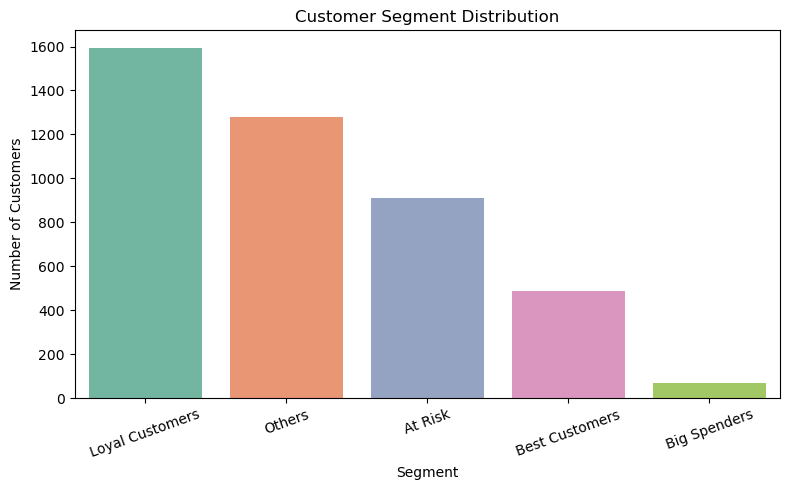

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')
plt.title("Customer Segment Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


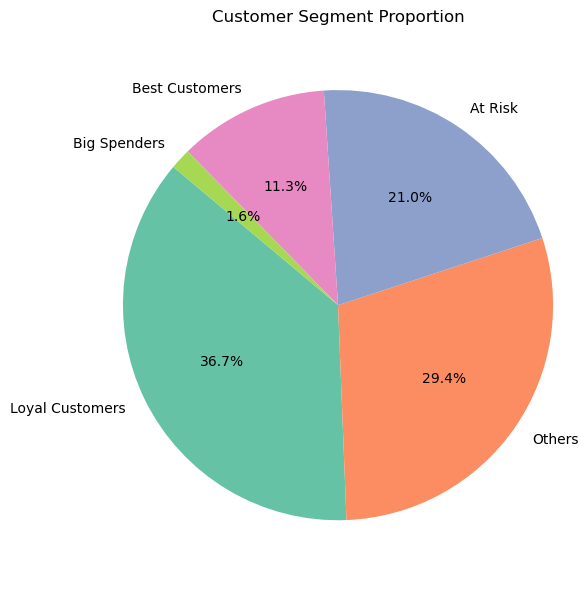

In [24]:
segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title("Customer Segment Proportion")
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle
plt.tight_layout()
plt.show()


In [25]:
# Features
X = rfm[['Recency', 'Frequency']]

# Target: Total money spent (our proxy for CLV)
y = rfm['Monetary']


In [26]:
from sklearn.model_selection import train_test_split

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R² Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)


R² Score: 0.24577291430463144
MAE: 1449.9766271210556
RMSE: 8079.5195276492495


In [29]:
# Average order value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# Frequency per day (proxy for engagement)
rfm['FrequencyPerDay'] = rfm['Frequency'] / (rfm['Recency'] + 1)

# Monetary per day (spending speed)
rfm['MonetaryPerDay'] = rfm['Monetary'] / (rfm['Recency'] + 1)

# Optional: Drop rows with inf or NaN (caused by division)
rfm = rfm.replace([np.inf, -np.inf], np.nan).dropna()


In [30]:
# Select enhanced features
X = rfm[['Recency', 'Frequency', 'AvgOrderValue', 'FrequencyPerDay', 'MonetaryPerDay']]

# Target variable remains the same
y = rfm['Monetary']


In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
from xgboost import XGBRegressor

# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,       # number of trees
    learning_rate=0.1,      # step size shrinkage
    max_depth=3,            # max depth of a tree
    random_state=42         # for reproducibility
)


In [33]:
# Fit model to training data
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [34]:
# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Evaluation metrics
r2 = r2_score(y_test, y_pred_xgb)
mae = mean_absolute_error(y_test, y_pred_xgb)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Print the results
print("XGBoost R² Score:", r2)
print("XGBoost MAE:", mae)
print("XGBoost RMSE:", rmse)


XGBoost R² Score: 0.9813790549969287
XGBoost MAE: 362.02295448859167
XGBoost RMSE: 1269.5076764894031


<Figure size 1000x600 with 0 Axes>

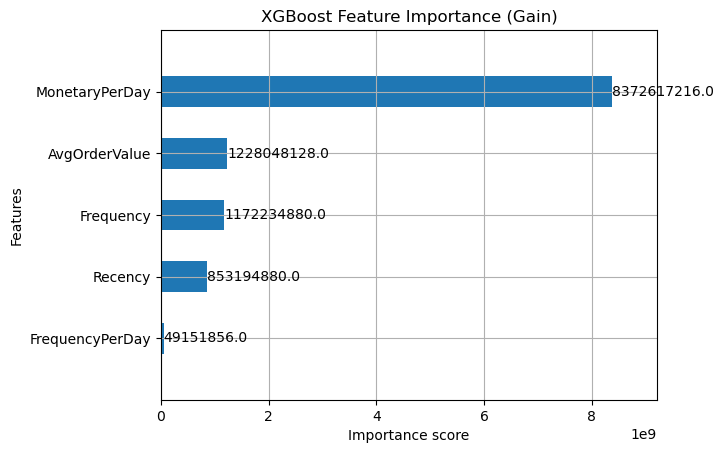

In [36]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plotting feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', height=0.5)
plt.title('XGBoost Feature Importance (Gain)')
plt.show()


In [38]:
# Add the predicted CLV to the RFM table (if not already added)
rfm['Predicted_CLV'] = xgb_model.predict(X)

# Export to CSV
rfm.to_csv("rfm_clv_tableau.csv", index=False)
